<a href="https://colab.research.google.com/github/jeffvun/Machine-Learning-Labs/blob/main/CNN_models_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Loading necessary libraries**

In [ ]:
!pip install vit-keras
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 9.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from vit_keras import vit, utils
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

from PIL import Image


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## **Data Preprocessing**

In [ ]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 4


In [ ]:
# Define data directories and categories
data_dir = '/content/drive/MyDrive/DataSet/train/ALL'
categories = ['Benign', 'Early', 'Pre', 'Pro']

# Create an empty DataFrame to store file paths and corresponding labels
data = []

# Load data by iterating through categories and collecting file paths
for category_id, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith('.jpg'):
          data.append((os.path.join(category_dir, filename), category))

In [ ]:
# Convert the data list into a DataFrame
data_df = pd.DataFrame(data, columns=['FilePath', 'Category'])

In [ ]:
# Split the data into training, testing, and validation sets
train_data, test_data = train_test_split(data_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Print the number of samples in each set
print(f"Number of samples in training set: {len(train_data)}")
print(f"Number of samples in testing set: {len(test_data)}")
print(f"Number of samples in validation set: {len(val_data)}")


Number of samples in training set: 2343
Number of samples in testing set: 652
Number of samples in validation set: 261


In [ ]:
# Create data generators
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col="FilePath",
    y_col="Category",
    target_size=(IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col="FilePath",
    y_col="Category",
    target_size=(IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col="FilePath",
    y_col="Category",
    target_size=(IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2343 validated image filenames belonging to 4 classes.
Found 261 validated image filenames belonging to 4 classes.
Found 652 validated image filenames belonging to 4 classes.


## **Loading and Compiling Various CNN models**

In [ ]:
# Load and compile SVM model
# Flatten the images for SVM
X_svm, y_svm = [], []

for i in range(len(train_generator)):
    batch_images, batch_labels = train_generator[i]
    batch_size = batch_images.shape[0]
    flattened_images = batch_images.reshape((batch_size, -1))
    X_svm.append(flattened_images)
    y_svm.append(np.argmax(batch_labels, axis=1))

X_svm = np.vstack(X_svm)
y_svm = np.concatenate(y_svm)

svm_model = SVC(kernel='linear')
svm_model.fit(X_svm, y_svm)


SVC(kernel='linear')

In [ ]:
# Load and compile CNN model
cnn_model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*IMAGE_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Load and compile ViT model
vit_model = vit.vit_b16(
    image_size=IMAGE_SIZE[0],
    activation='softmax',
    pretrained=False,
    include_top=True,
    pretrained_top=False,
    classes=4
)

vit_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Load and compile ResNet model
base_model = ResNet50(input_shape=(*IMAGE_SIZE, 3),weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=base_model.input, outputs=predictions)

resnet_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
# Load and configure MobileNetV2 model
base_model = MobileNetV2(
    input_shape=(*IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet",
)
#Adding custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False
# Compile the model
mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 [==============================] - 1s 0us/step


## **Training and Evaluating Various CNN Models**

In [ ]:
# Train CNN, ViT, ResNet and mobilenet models

history_cnn = cnn_model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, verbose=1)
history_vit = vit_model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, verbose=1)
history_resnet = resnet_model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)
history_mobilenet = mobilenet_model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, verbose=1)


Epoch 1/10
74/74 [==============================] - 216s 3s/step - loss: 7.7441 - accuracy: 0.5019 - val_loss: 0.7747 - val_accuracy: 0.7165
Epoch 2/10
74/74 [==============================] - 44s 599ms/step - loss: 0.6384 - accuracy: 0.7606 - val_loss: 0.5964 - val_accuracy: 0.7625
Epoch 3/10
74/74 [==============================] - 42s 571ms/step - loss: 0.5047 - accuracy: 0.8148 - val_loss: 0.4796 - val_accuracy: 0.8123
Epoch 4/10
74/74 [==============================] - 43s 582ms/step - loss: 0.4431 - accuracy: 0.8280 - val_loss: 0.3911 - val_accuracy: 0.8851
Epoch 5/10
74/74 [==============================] - 43s 575ms/step - loss: 0.4152 - accuracy: 0.8455 - val_loss: 0.3563 - val_accuracy: 0.8659
Epoch 6/10
74/74 [==============================] - 43s 580ms/step - loss: 0.4033 - accuracy: 0.8429 - val_loss: 0.3506 - val_accuracy: 0.8774
Epoch 7/10
74/74 [==============================] - 44s 597ms/step - loss: 0.3867 - accuracy: 0.8621 - val_loss: 0.3857 - val_accuracy: 0.8429
E

In [ ]:
# Evaluate SVM model
X_test_svm, y_test_svm = [], []

for i in range(len(val_generator)):
    batch_images, batch_labels = val_generator[i]
    batch_size = batch_images.shape[0]
    flattened_images = batch_images.reshape((batch_size, -1))
    X_test_svm.append(flattened_images)
    y_test_svm.append(np.argmax(batch_labels, axis=1))

X_test_svm = np.vstack(X_test_svm)
y_test_svm = np.concatenate(y_test_svm)

svm_predictions = svm_model.predict(X_test_svm)
svm_accuracy = accuracy_score(y_test_svm, svm_predictions)
svm_f1 = f1_score(y_test_svm, svm_predictions, average='weighted')
svm_cm = confusion_matrix(y_test_svm, svm_predictions)


In [ ]:
# Evaluate CNN model
cnn_predictions = []
cnn_true_labels = []

for i in range(len(val_generator)):
    batch_images, batch_labels = val_generator[i]
    batch_size = batch_images.shape[0]

    # Get true labels
    cnn_true_labels.extend(np.argmax(batch_labels, axis=1))

    # Get predictions
    batch_predictions = cnn_model.predict(batch_images)
    cnn_predictions.extend(np.argmax(batch_predictions, axis=1))

cnn_f1 = f1_score(cnn_true_labels, cnn_predictions, average='weighted')
cnn_eval = cnn_model.evaluate(val_generator)
cnn_cm = confusion_matrix(cnn_true_labels, cnn_predictions)


9/9 [==============================] - 6s 635ms/step - loss: 0.2997 - accuracy: 0.8927


In [ ]:
# # Evaluate ViT model
# vit_eval = vit_model.evaluate(val_generator)
# vit_f1 = f1_score(np.argmax(val_generator.labels, axis=1), np.argmax(vit_model.predict(val_generator), axis=1), average='weighted')
# vit_cm = confusion_matrix(np.argmax(val_generator.labels, axis=1), np.argmax(vit_model.predict(val_generator), axis=1))


In [ ]:
# Evaluate ViT model
vit_predictions = []
vit_true_labels = []

for i in range(len(val_generator)):
    batch_images, batch_labels = val_generator[i]
    batch_size = batch_images.shape[0]

    # Get true labels
    vit_true_labels.extend(np.argmax(batch_labels, axis=1))

    # Get predictions
    batch_predictions = vit_model.predict(batch_images)
    vit_predictions.extend(np.argmax(batch_predictions, axis=1))

vit_f1 = f1_score(vit_true_labels, vit_predictions, average='weighted')
vit_eval = vit_model.evaluate(val_generator)
vit_cm = confusion_matrix(vit_true_labels, vit_predictions)


9/9 [==============================] - 5s 527ms/step - loss: 0.3683 - accuracy: 0.8314


In [ ]:
# Evaluate ResNet model
resnet_predictions = []
resnet_true_labels = []

for i in range(len(val_generator)):
    batch_images, batch_labels = val_generator[i]
    batch_size = batch_images.shape[0]

    # Get true labels
    resnet_true_labels.extend(np.argmax(batch_labels, axis=1))

    # Get predictions
    batch_predictions = resnet_model.predict(batch_images)
    resnet_predictions.extend(np.argmax(batch_predictions, axis=1))

resnet_f1 = f1_score(resnet_true_labels, resnet_predictions, average='weighted')
resnet_eval = resnet_model.evaluate(val_generator)
resnet_cm = confusion_matrix(resnet_true_labels, resnet_predictions)


9/9 [==============================] - 5s 445ms/step - loss: 1.5884 - accuracy: 0.6015


In [ ]:
# Evaluate MobileNet model
mobilenet_predictions = []
mobilenet_true_labels = []

for i in range(len(val_generator)):
    batch_images, batch_labels = val_generator[i]
    batch_size = batch_images.shape[0]

    # Get true labels
    mobilenet_true_labels.extend(np.argmax(batch_labels, axis=1))

    # Get predictions
    batch_predictions = mobilenet_model.predict(batch_images)
    mobilenet_predictions.extend(np.argmax(batch_predictions, axis=1))

mobilenet_f1 = f1_score(mobilenet_true_labels, mobilenet_predictions, average='weighted')
mobilenet_eval = mobilenet_model.evaluate(val_generator)
mobilenet_cm = confusion_matrix(mobilenet_true_labels, mobilenet_predictions)


9/9 [==============================] - 6s 679ms/step - loss: 0.0790 - accuracy: 0.9655


## **Models Summary**

In [ ]:
# Print and compare metrics
print("SVM Accuracy:", svm_accuracy)
print("SVM F1 Score:", svm_f1)
print("SVM Confusion Matrix:\n", svm_cm)


SVM Accuracy: 0.7203065134099617
SVM F1 Score: 0.7179997376079749
SVM Confusion Matrix:
 [[17  5  8  7]
 [13 57 12  3]
 [ 3 15 52  1]
 [ 3  3  0 62]]


In [ ]:
print("CNN Accuracy:", cnn_eval[1])
print("CNN F1 Score:", cnn_f1)
print("CNN Confusion Matrix:\n", cnn_cm)


CNN Accuracy: 0.8927202820777893
CNN F1 Score: 0.8831982792238645
CNN Confusion Matrix:
 [[17 13  3  4]
 [ 2 82  0  1]
 [ 4  1 66  0]
 [ 0  0  0 68]]


In [ ]:
print("ViT Accuracy:", vit_eval[1])
print("ViT F1 Score:", vit_f1)
print("ViT Confusion Matrix:\n", vit_cm)


ViT Accuracy: 0.8314176201820374
ViT F1 Score: 0.7886134727755028
ViT Confusion Matrix:
 [[ 1 30  3  3]
 [ 1 81  2  1]
 [ 0  0 71  0]
 [ 0  0  1 67]]


In [ ]:
print("ResNet Accuracy:", resnet_eval[1])
print("ResNet F1 Score:", resnet_f1)
print("ResNet Confusion Matrix:\n", resnet_cm)


ResNet Accuracy: 0.6015325784683228
ResNet F1 Score: 0.53869474402737
ResNet Confusion Matrix:
 [[11  6 13  7]
 [ 2 17 33 33]
 [ 1  1 60  9]
 [ 0  0  0 68]]


In [ ]:
print("MobileNet Accuracy:", mobilenet_eval[1])
print("MobileNet F1 Score:", mobilenet_f1)
print("MobileNet Confusion Matrix:\n", mobilenet_cm)


MobileNet Accuracy: 0.9655172228813171
MobileNet F1 Score: 0.9653769251788469
MobileNet Confusion Matrix:
 [[32  5  0  0]
 [ 3 82  0  0]
 [ 0  1 70  0]
 [ 0  0  0 68]]


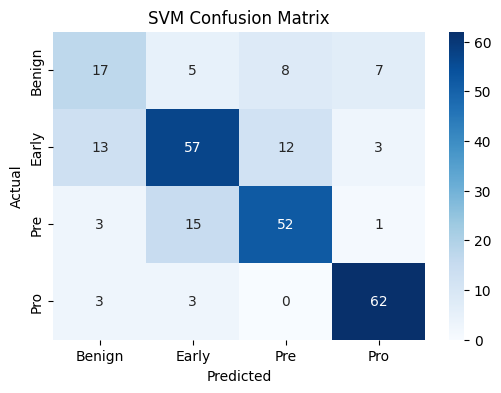

In [ ]:
target_names = ['Benign', 'Early', 'Pre', 'Pro']

# Plot the svm confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()


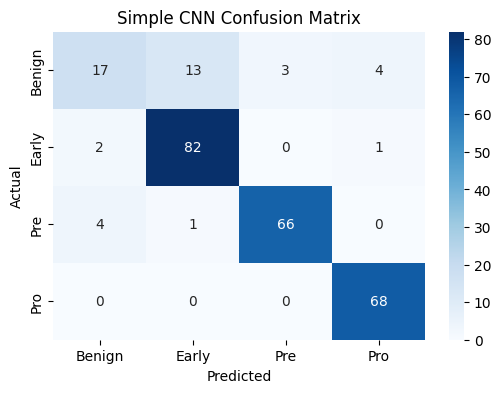

In [ ]:
# Plot the cnn confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Simple CNN Confusion Matrix')
plt.show()

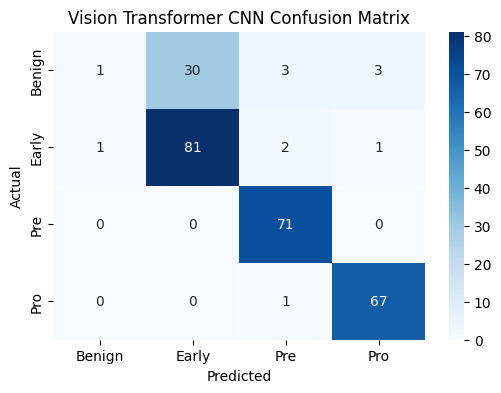

In [ ]:
# Plot the Vit confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(vit_cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Vision Transformer CNN Confusion Matrix')
plt.show()

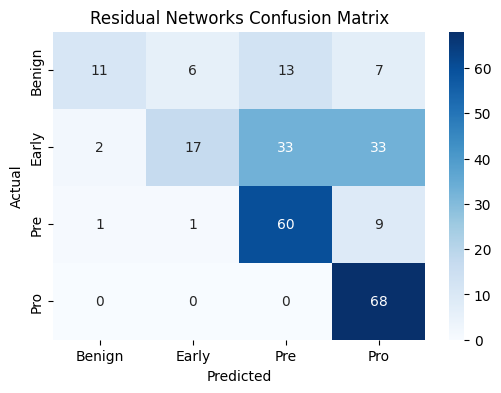

In [ ]:
# Plot the resnet confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(resnet_cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Residual Networks Confusion Matrix')
plt.show()

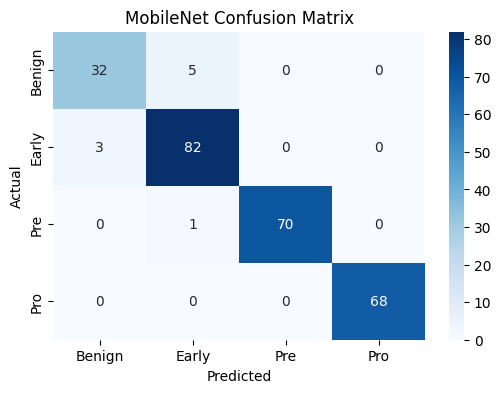

In [ ]:
# Plot the mobilenet confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(mobilenet_cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('MobileNet Confusion Matrix')
plt.show()

## **Testing the models on a sample**

In [ ]:
# Load an example image for prediction
sample_image_path = '/content/WBC-Malignant-Pro-800.jpg'
sample_image = keras.preprocessing.image.load_img(sample_image_path, target_size=IMAGE_SIZE)
sample_image_array = keras.preprocessing.image.img_to_array(sample_image)
sample_image_array = np.expand_dims(sample_image_array, axis=0)

In [ ]:
# Predictions using the trained models
flattened_sample_image_array = sample_image_array.reshape((1, -1))
svm_pred = svm_model.predict(flattened_sample_image_array)
cnn_pred = cnn_model.predict(sample_image_array)
vit_pred = vit_model.predict(sample_image_array)
resnet_pred = resnet_model.predict(sample_image_array)
mobilenet_pred = mobilenet_model.predict(sample_image_array)

# Print predictions
print("SVM Predictions:", svm_pred)
print("CNN Predictions:", cnn_pred)
print("ViT Predictions:", vit_pred)
print("ResNet Predictions:", resnet_pred)
print("MobileNet Predictions:", mobilenet_pred)

1/1 [==============================] - 0s 279ms/step
SVM Predictions: [3]
CNN Predictions: [[1. 0. 0. 0.]]
ViT Predictions: [[5.4158431e-01 4.5454043e-01 1.9150392e-04 3.6837338e-03]]
ResNet Predictions: [[0. 1. 0. 0.]]
MobileNet Predictions: [[4.8797660e-02 7.8972585e-02 8.7219703e-01 3.2774766e-05]]


In [ ]:
# Export the models to a directory

cnn_model.save('leukemia_classifier_cnn_model')
vit_model.save('leukemia_classifier_vit_model')
resnet_model.save('leukemia_classifier_resnet_model')
mobilenet_model.save('leukemia_classifier_mobilenet_model')


In [ ]:
# Save the Keras model architecture and weights

cnn_model.save("leukemia_keras_cnn_model.h5")
vit_model.save("leukemia_keras_vit_model.h5")
resnet_model.save("leukemia_keras_resnet_model.h5")
mobilenet_model.save("leukemia_keras_mobilenet_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
